In [ ]:
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.metrics

In [ ]:
#Training on C2  and testing on C3
NS_case1 = pd.read_excel("/content/drive/My Drive/Projects/NS matter stuff/NS_EOS_Case1.xlsx")
NS_case2 = pd.read_excel("/content/drive/My Drive/Projects/NS matter stuff/NS_EOS_Case2.xlsx")
NS_case3 = pd.read_excel("/content/drive/My Drive/Projects/NS matter stuff/NS_EOS_Case3.xlsx")
NS = pd.concat([NS_case1,NS_case2],ignore_index=True)
X = NS_case2.iloc[:, 0:7].values
y = NS_case2.iloc[:, [7,9,11]].values
X_test = NS_case3.iloc[:, 0:7].values
y_test = NS_case3.iloc[:, [7,9,11]].values


In [ ]:
#Standardizing the data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)
X_test = sc_X.transform(X_test)
sc_y = StandardScaler()
y = sc_y.fit_transform(y)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers
from tensorflow.keras.layers import Layer

import tensorflow_probability as tfp


class DenseVariational(Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5, **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.init_sigma = np.sqrt(self.prior_pi_1 * self.prior_sigma_1 ** 2 +
                                  self.prior_pi_2 * self.prior_sigma_2 ** 2)

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def build(self, input_shape):
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.random_normal(stddev=self.init_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.random_normal(stddev=self.init_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)

        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) +
                      self.kl_loss(bias, self.bias_mu, bias_sigma))

        return self.activation(K.dot(inputs, kernel) + bias)

    def kl_loss(self, w, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return self.kl_weight * K.sum(variational_dist.log_prob(w) - self.log_prior_prob(w))

    def log_prior_prob(self, w):
        comp_1_dist = tfp.distributions.Normal(0.0, self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0, self.prior_sigma_2)
        return K.log(self.prior_pi_1 * comp_1_dist.prob(w) +
                     self.prior_pi_2 * comp_2_dist.prob(w))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

train_size = X.shape[0]
noise=0.01    #aleatoric uncertainity.... noise in the training data

batch_size = 32
num_batches = train_size / batch_size

kl_weight = 1.0 / num_batches
prior_params = {
    'prior_sigma_1': 2.5, 
    'prior_sigma_2': 0.1, 
    'prior_pi': 0.5 
}

x_in = Input(shape=(7,))
x = DenseVariational(16, kl_weight, **prior_params, activation='relu')(x_in)
x = DenseVariational(12, kl_weight, **prior_params, activation='relu')(x)
x = DenseVariational(3, kl_weight, **prior_params)(x)

model = Model(x_in, x)
from keras import callbacks, optimizers

def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

model.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=1e-10), metrics=['mse'])
history = model.fit(X, y, batch_size=batch_size, epochs=1000, verbose=0);

dict_keys(['loss', 'mse'])


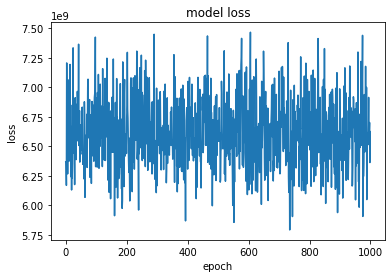

In [ ]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
import tqdm

y_pred_list_mass = np.zeros(X_test.shape[0])
y_pred_list_rad = np.zeros(X_test.shape[0])
y_pred_list_lam = np.zeros(X_test.shape[0])

for i in tqdm.tqdm(range(500)):
    y_pred = model.predict(X_test)
    y_pred = sc_y.inverse_transform(y_pred)
    y_pred_list_mass = np.vstack((y_pred_list_mass,y_pred[:,0]))
    y_pred_list_rad = np.vstack((y_pred_list_rad,y_pred[:,1]))
    y_pred_list_lam = np.vstack((y_pred_list_lam,y_pred[:,2]))
    
y_pred_mass = np.delete(y_pred_list_mass,0, axis=0)
y_pred_rad = np.delete(y_pred_list_rad,0, axis=0)
y_pred_lam = np.delete(y_pred_list_lam,0, axis=0)

100%|██████████| 500/500 [00:44<00:00, 11.18it/s]


In [ ]:
y_pred_mass

array([[   13.48367596,  -161.81750488,  -102.44037628, ...,
         -505.74536133,  -554.60168457,  -527.59338379],
       [ -922.61810303,  -891.5279541 ,  -922.66381836, ...,
          -35.39372635,   140.29187012,   121.22531891],
       [-1575.56994629,  -763.05810547,  -858.45336914, ...,
         -495.06787109,  -544.40563965,  -523.35906982],
       ...,
       [ -440.76315308,  -542.09997559,  -548.90124512, ...,
        -1146.94421387, -1059.17590332, -1042.55700684],
       [ -247.7379303 ,  -281.449646  ,  -246.22268677, ...,
          -80.17240906,  -236.00656128,  -288.45046997],
       [-1492.40380859, -2288.2578125 , -2463.55395508, ...,
         -834.80047607,  -668.79724121,  -676.74151611]])

In [ ]:
y_mean_mass = np.mean(y_pred_mass, axis=0).transpose()
y_std_mass = np.std(y_pred_mass, axis=0).transpose()

y_mean_rad = np.mean(y_pred_rad, axis=0).transpose()
y_std_rad = np.std(y_pred_rad, axis=0).transpose()

y_mean_lam = np.mean(y_pred_lam, axis=0).transpose()
y_std_lam = np.std(y_pred_lam, axis=0).transpose()
y_mean_mass.shape

(2679,)

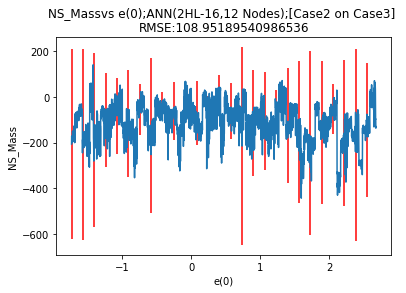

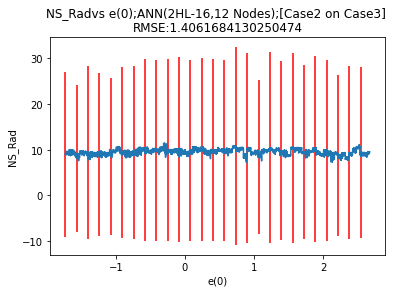

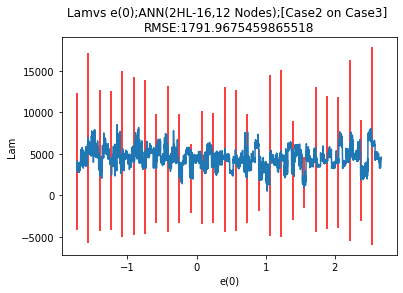

In [ ]:
#plot of values and error bars
y_mean = np.vstack((y_mean_mass,y_mean_rad,y_mean_lam)).transpose()
y_std = np.vstack((y_std_mass,y_std_rad,y_std_lam)).transpose()
titles = ['NS_Mass','NS_Rad','Lam']
for i in range(3):
    rms = 'RMSE:'+str((np.sqrt(sklearn.metrics.mean_squared_error(y_test[:,i], y_mean[:,i]))))
    fig, ax = plt.subplots()
    ax.errorbar(X_test[:,0],y_mean[:,i],yerr=2*y_mean[:,i],errorevery=100,ecolor='red')
    ax.set_ylabel(titles[i])
    ax.set_xlabel('e(0)')
    plt.title(titles[i]+'vs e(0);ANN(2HL-16,12 Nodes);[Case2 on Case3] \n'+rms)
    plt.show()

In [ ]:
#RMS value
rms = sklearn.metrics.mean_squared_error(y_test, y_mean)**0.5
rms_mass = sklearn.metrics.mean_squared_error(y_test[:,0], y_mean[:,0])**0.5
rms_rad = sklearn.metrics.mean_squared_error(y_test[:,1], y_mean[:,1])**0.5
rms_lam = sklearn.metrics.mean_squared_error(y_test[:,2], y_mean[:,2])**0.5

#R2 value
r2 = sklearn.metrics.r2_score(y_test,y_mean)

result_new = pd.DataFrame(columns=['Model','RMS','RMS_NS_Mass','RMS_NS_Rad','RMS_Lam','R2'])

result_new = result_new.append({'Model':'BNN(2HL-16,12 Nodes)', 'RMS':rms,'RMS_NS_Mass':rms_mass,'RMS_NS_Rad':rms_rad,
                        'RMS_Lam':rms_lam, 'R2':r2}, ignore_index=True)

result_new

,Model,RMS,RMS_NS_Mass,RMS_NS_Rad,RMS_Lam,R2
0,"BNN(2HL-16,12 Nodes)",1036.503767,108.951895,1.406168,1791.967546,-3.837083


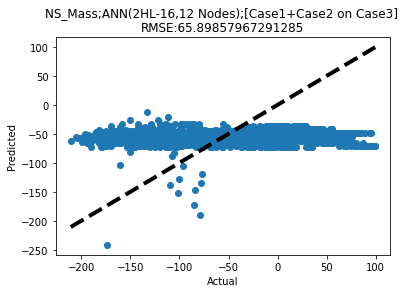

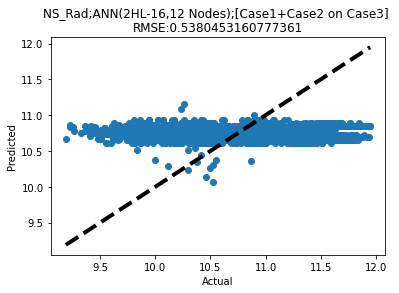

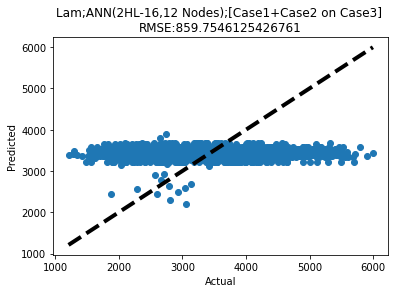

In [ ]:
#Plotting
titles = ['NS_Mass','NS_Rad','Lam']
for i in range(3):
    rms = 'RMSE:'+str((np.sqrt(sklearn.metrics.mean_squared_error(y_test[:,i], y_mean[:,i]))))
    fig, ax = plt.subplots()
    ax.scatter(y_test[:,i], y_mean[:,i])
    ax.plot([y_test[:,i].min(), y_test[:,i].max()], [y_test[:,i].min(), y_test[:,i].max()], 'k--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    plt.title(titles[i]+';ANN(2HL-16,12 Nodes);[Case2 on Case3] \n'+rms)
    plt.show()